In [1]:
!pip install -q onnx onnxruntime retinaface

ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tensorlayer 2.1.0 requires requests==2.21.0, but you'll have requests 2.25.1 which is incompatible.
tensorlayer 2.1.0 requires scipy==1.2.1, but you'll have scipy 1.4.1 which is incompatible.
flask 2.0.1 requires Werkzeug>=2.0, but you'll have werkzeug 1.0.1 which is incompatible.


In [1]:
!pip install onnxruntime==1.6

     |████████████████████████████████| 4.1 MB 378 kB/s eta 0:00:01
  Attempting uninstall: onnxruntime
    Found existing installation: onnxruntime 1.9.0
    Uninstalling onnxruntime-1.9.0:
      Successfully uninstalled onnxruntime-1.9.0


In [1]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import onnxruntime as ort
import matplotlib.pyplot as plt
from skimage import transform as trans
from sklearn.preprocessing import normalize

In [2]:
def load_data(folder_path):
    names = os.listdir(folder_path)
    if '.ipynb_checkpoints' in names:
        names.remove(".ipynb_checkpoints")
    data = {}
    total_face = 0
    for roots, dirs, files in os.walk(folder_path):
        if roots.find(".ipynb_checkpoints") == -1:
            name = roots.split('/')[-1]
            if name in names: 
                data[name] = []
                for file in files:
                    total_face += 1
                    data[name].append(os.path.join(roots, file))
    print('total face:', total_face)
    return data

In [3]:
def aligned_face(img, landmark):
    src = np.array([
        [30.2946, 51.6963],
        [65.5318, 51.5014],
        [48.0252, 71.7366],
        [33.5493, 92.3655],
        [62.7299, 92.2041] ], dtype=np.float32)
    dst = np.array(landmark, dtype=np.float32).reshape(5, 2)
    tform = trans.SimilarityTransform()
    tform.estimate(dst, src)
    M = tform.params[0:2,:]
    aligned = cv2.warpAffine(img, M, (112, 112), borderValue = 0)
    return aligned

In [4]:
def get_embeddings(extractor, img):
    img = (img/255-0.5)/0.5
    img = img.transpose((2, 0, 1))
    inputs = np.expand_dims(img, axis=0)
    input_name = extractor.get_inputs()[0].name
    embedding = extractor.run(None, {input_name: inputs})[0]
    outputs = normalize(embedding).flatten()
    return outputs

In [5]:
# load face data from database
folder_path = 'database'
data = load_data(folder_path)

total face: 5


In [6]:
# load RetinaFace detector
from retinaface import RetinaFace
# init with normal accuracy option
detector = RetinaFace(quality="normal")
# load facenet model
onnx_path = "model/model.onnx"
extractor = ort.InferenceSession(onnx_path)

model[normal quality] init ..
model success !


database/MaYingJeou/MaYingJeou.jpg
database/Hirosue_Ryoko/Hirosue_Ryoko.jpg
database/Aragaki_Yui/Aragaki_Yui.png
database/TsaiIngWen/TsaiIngWen.png
database/Chiang_Tsu_Ping/Chiang_Tsu_Ping.png


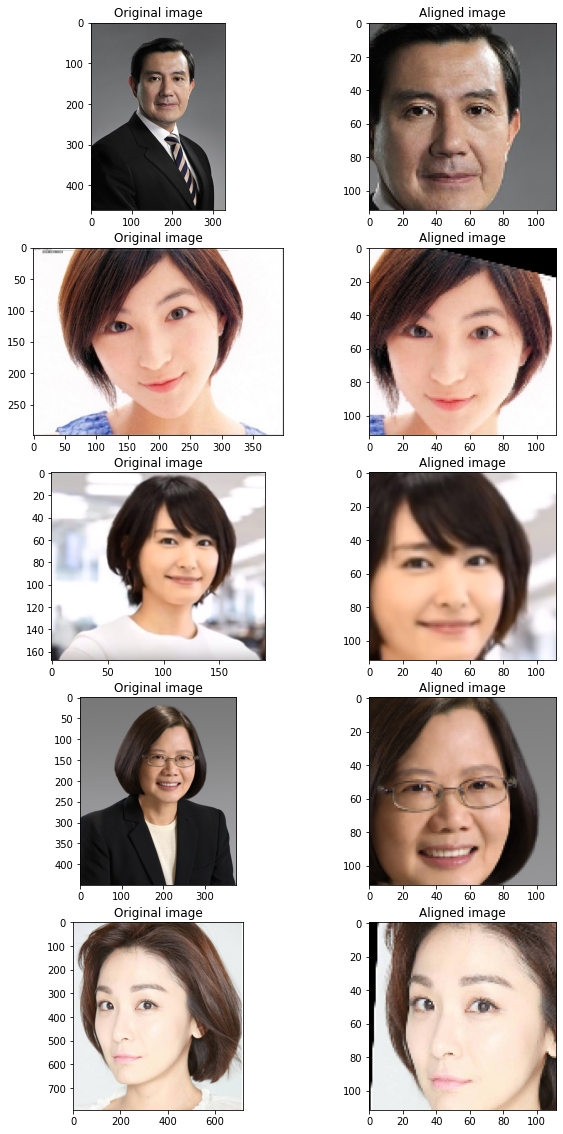

In [7]:
plt.figure(figsize=(10, 20))
n = len(data)
allembeddings = np.zeros([len(data), 512])
for j, name in enumerate(data.keys()):
    embeddings = np.zeros([len(data[name]), 512])
    for i, file in enumerate(data[name]):
        print(file)
        imgBGR = cv2.imread(file, cv2.IMREAD_COLOR).astype('float32')
        imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
        # plot raw image
        plt.subplot(n,2,2*j+1)
        plt.imshow(imgRGB/255)
        plt.title('Original image', fontsize=12)
        # detect faces in the image
        facePosition = detector.predict(imgRGB)[0]
        # extract the landmark from the face
        x1, y1 = facePosition.pop('x1'), facePosition.pop('y1')
        x2, y2 = facePosition.pop('x2'), facePosition.pop('y2')
        landmark = list(facePosition.values())
        # aligned image with landmark
        aligned = aligned_face(imgRGB, landmark)
        # plot aligned image
        plt.subplot(n,2,2*j+2)
        plt.imshow(aligned/255)
        plt.title('Aligned image', fontsize=12)
        # extract faces and calculate face embeddings for the photo files
        embeddings[i] = get_embeddings(extractor, aligned)
    # calculate mean of the embeddings
    allembeddings[j] = embeddings.mean(0)
plt.show()

In [8]:
db = {'names': list(data.keys()), 'embeddings': allembeddings}
with open('db.pkl', 'wb') as file:
    pickle.dump(db, file)